In [1]:
%env JAVA_HOME=/usr/lib/jvm/java-11-openjdk-11.0.25.0.9-2.el8.x86_64
%env PATH=/storage/home/yqf5148/work/anaconda3/envs/volvopennstate-env/bin:storage/icds/swst/deployed/production/20220813/apps/anaconda3/2021.05_gcc-8.5.0/bin:/usr/lib/jvm/java-11-openjdk-11.0.25.0.9-2.el8.x86_64/bin/java:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/storage/icds/tools/bin:/storage/sys/slurm/bin:/storage/icds/tools/bin:/storage/sys/slurm/bin:/storage/icds/tools/bin:/storage/sys/slurm/bin:/storage/icds/tools/bin:/storage/sys/slurm/bin:/storage/icds/tools/bin:/storage/sys/slurm/bin

env: JAVA_HOME=/usr/lib/jvm/java-11-openjdk-11.0.25.0.9-2.el8.x86_64
env: PATH=/storage/home/yqf5148/work/anaconda3/envs/volvopennstate-env/bin:storage/icds/swst/deployed/production/20220813/apps/anaconda3/2021.05_gcc-8.5.0/bin:/usr/lib/jvm/java-11-openjdk-11.0.25.0.9-2.el8.x86_64/bin/java:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/storage/icds/tools/bin:/storage/sys/slurm/bin:/storage/icds/tools/bin:/storage/sys/slurm/bin:/storage/icds/tools/bin:/storage/sys/slurm/bin:/storage/icds/tools/bin:/storage/sys/slurm/bin:/storage/icds/tools/bin:/storage/sys/slurm/bin


In [2]:
import findspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pyspark as psk
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as f
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql import DataFrame
from pyspark.sql.functions import *

import time as t 
from datetime import date, datetime, timedelta
from joblib import Parallel, delayed
import multiprocessing
from functools import reduce  
from math import modf
import sqlite3
import os
import sys

from delta import * 
from delta.tables import *
from delta import configure_spark_with_delta_pip
from IPython import get_ipython

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from scipy.spatial.distance import hamming


# Create SparkSession 
spark = SparkSession.builder \
       .master("local[2]") \
       .appName("test") \
       .config("spark.driver.maxResultSize", "20g")\
       .config("spark.driver.memory", "100g")\
       .getOrCreate()

spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")    #To resolve the error for p1075_38 to_timestamp formating: You may get a different result due to the upgrading to Spark >= 3.0: Fail to parse '1/2/2019 20:40:00' in the new parser. You can set spark.sql.legacy.timeParserPolicy to LEGACY to restore the behavior before Spark 3.0, or set to CORRECTED and treat it as an invalid datetime string.

spark.read.option("header",True) \
          .csv("/storage/home/yqf5148/work/volvoPennState/PopulationWithChassisId.csv") \
          .createOrReplaceTempView("population")

df_population = spark.sql("SELECT * FROM population")

ps: /storage/icds/RISE/sw8/anaconda/anaconda3/envs/tensorflow/lib/libuuid.so.1: no version information available (required by /usr/lib64/libblkid.so.1)
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/13 16:21:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/13 16:21:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/01/13 16:21:49 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/01/13 16:21:49 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
25/01/13 16:21:54 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [3]:
calculated_features_minus_calendar_day = [     
          "f_1_dtc38_1th_15d", 
          "f_1_dtc38_2nd_15d", 
          "f_2_dtc38_1th_15d", 
          "f_2_dtc38_2nd_15d", 
          "f_3_dtc38_1th_15d", 
          "f_3_dtc38_2nd_15d", 
          "f_4_dtc38_1th_15d", 
          "f_4_dtc38_2nd_15d", 
          "f_5_dtc38_1th_15d", 
          "f_5_dtc38_2nd_15d", 
          "f_6_dtc38_1th_15d", 
          "f_6_dtc38_2nd_15d", 
          "f_7_dtc38_1th_15d", 
          "f_7_dtc38_2nd_15d", 
          "f_8_dtc38_1th_15d", 
          "f_8_dtc38_2nd_15d", 

          "f_1_dtc75_1th_15d", 
          "f_1_dtc75_2nd_15d", 
          "f_2_dtc75_1th_15d", 
          "f_2_dtc75_2nd_15d", 
          "f_3_dtc75_1th_15d", 
          "f_3_dtc75_2nd_15d", 
          "f_4_dtc75_1th_15d", 
          "f_4_dtc75_2nd_15d", 
          "f_5_dtc75_1th_15d", 
          "f_5_dtc75_2nd_15d", 
          "f_6_dtc75_1th_15d", 
          "f_6_dtc75_2nd_15d", 
          "f_7_dtc75_1th_15d", 
          "f_7_dtc75_2nd_15d", 
          "f_8_dtc75_1th_15d", 
          "f_8_dtc75_2nd_15d",


          "f_1_dtc77_1th_15d", 
          "f_1_dtc77_2nd_15d", 
          "f_2_dtc77_1th_15d", 
          "f_2_dtc77_2nd_15d", 
          "f_3_dtc77_1th_15d", 
          "f_3_dtc77_2nd_15d", 
          "f_4_dtc77_1th_15d", 
          "f_4_dtc77_2nd_15d", 
          "f_5_dtc77_1th_15d", 
          "f_5_dtc77_2nd_15d", 
          "f_6_dtc77_1th_15d", 
          "f_6_dtc77_2nd_15d", 
          "f_7_dtc77_1th_15d", 
          "f_7_dtc77_2nd_15d", 
          "f_8_dtc77_1th_15d", 
          "f_8_dtc77_2nd_15d",


          "f_1_dtc86_1th_15d", 
          "f_1_dtc86_2nd_15d", 
          "f_2_dtc86_1th_15d", 
          "f_2_dtc86_2nd_15d", 
          "f_3_dtc86_1th_15d", 
          "f_3_dtc86_2nd_15d", 
          "f_4_dtc86_1th_15d", 
          "f_4_dtc86_2nd_15d", 
          "f_5_dtc86_1th_15d", 
          "f_5_dtc86_2nd_15d", 
          "f_6_dtc86_1th_15d", 
          "f_6_dtc86_2nd_15d", 
          "f_7_dtc86_1th_15d", 
          "f_7_dtc86_2nd_15d", 
          "f_8_dtc86_1th_15d", 
          "f_8_dtc86_2nd_15d",


          "f_1_dtc92_1th_15d", 
          "f_1_dtc92_2nd_15d", 
          "f_2_dtc92_1th_15d", 
          "f_2_dtc92_2nd_15d", 
          "f_3_dtc92_1th_15d", 
          "f_3_dtc92_2nd_15d", 
          "f_4_dtc92_1th_15d", 
          "f_4_dtc92_2nd_15d", 
          "f_5_dtc92_1th_15d", 
          "f_5_dtc92_2nd_15d", 
          "f_6_dtc92_1th_15d", 
          "f_6_dtc92_2nd_15d", 
          "f_7_dtc92_1th_15d", 
          "f_7_dtc92_2nd_15d", 
          "f_8_dtc92_1th_15d", 
          "f_8_dtc92_2nd_15d",


          "f_1_dtc94_1th_15d", 
          "f_1_dtc94_2nd_15d", 
          "f_2_dtc94_1th_15d", 
          "f_2_dtc94_2nd_15d", 
          "f_3_dtc94_1th_15d", 
          "f_3_dtc94_2nd_15d", 
          "f_4_dtc94_1th_15d", 
          "f_4_dtc94_2nd_15d", 
          "f_5_dtc94_1th_15d", 
          "f_5_dtc94_2nd_15d", 
          "f_6_dtc94_1th_15d", 
          "f_6_dtc94_2nd_15d", 
          "f_7_dtc94_1th_15d", 
          "f_7_dtc94_2nd_15d", 
          "f_8_dtc94_1th_15d", 
          "f_8_dtc94_2nd_15d",


          "f_1_dtc0401_1th_15d", 
          "f_1_dtc0401_2nd_15d", 
          "f_2_dtc0401_1th_15d", 
          "f_2_dtc0401_2nd_15d", 
          "f_3_dtc0401_1th_15d", 
          "f_3_dtc0401_2nd_15d", 
          "f_4_dtc0401_1th_15d", 
          "f_4_dtc0401_2nd_15d", 
          "f_5_dtc0401_1th_15d", 
          "f_5_dtc0401_2nd_15d", 
          "f_6_dtc0401_1th_15d", 
          "f_6_dtc0401_2nd_15d", 
          "f_7_dtc0401_1th_15d", 
          "f_7_dtc0401_2nd_15d", 
          "f_8_dtc0401_1th_15d", 
          "f_8_dtc0401_2nd_15d",


          "f_1_dtc2457_1th_15d", 
          "f_1_dtc2457_2nd_15d", 
          "f_2_dtc2457_1th_15d", 
          "f_2_dtc2457_2nd_15d", 
          "f_3_dtc2457_1th_15d", 
          "f_3_dtc2457_2nd_15d", 
          "f_4_dtc2457_1th_15d", 
          "f_4_dtc2457_2nd_15d", 
          "f_5_dtc2457_1th_15d", 
          "f_5_dtc2457_2nd_15d", 
          "f_6_dtc2457_1th_15d", 
          "f_6_dtc2457_2nd_15d", 
          "f_7_dtc2457_1th_15d", 
          "f_7_dtc2457_2nd_15d", 
          "f_8_dtc2457_1th_15d", 
          "f_8_dtc2457_2nd_15d",

          "if_parts_replaced_in_1th_15d", 
          "if_parts_replaced_in_2nd_15d"]

In [4]:
all_columns_names_for_agg = ['VIN','ENGINE_SIZE','ENGINE_HP','VEH_TYPE']+[s for s in df_population.columns if 'KOLA' in s] + calculated_features_minus_calendar_day
# print(len(['VIN','ENGINE_SIZE','ENGINE_HP','VEH_TYPE']+[s for s in df_population.columns if 'KOLA' in s]+ calculated_features_minus_calendar_day))
aggregated_train_df = pd.read_csv('/storage/home/yqf5148/work/volvoPennState/data/dataset/aggregated_train_df.csv', sep=',', names=all_columns_names_for_agg, header=None)
aggregated_test_df= pd.read_csv('/storage/home/yqf5148/work/volvoPennState/data/dataset/aggregated_test_df.csv', sep=',', names=all_columns_names_for_agg, header=None)
print(aggregated_train_df.shape)
print(aggregated_test_df.shape)

(845, 722)
(213, 722)


In [5]:
print(aggregated_train_df.iloc[:, 721])  # col[0] is VIN, col[1] to col[591] KOLA features. col[591] to col[720] are calculated features. 

0      0
1      0
2      0
3      0
4      0
      ..
840    0
841    0
842    0
843    0
844    0
Name: if_parts_replaced_in_2nd_15d, Length: 845, dtype: int64


# Finding out the Optimal Number for Clusters

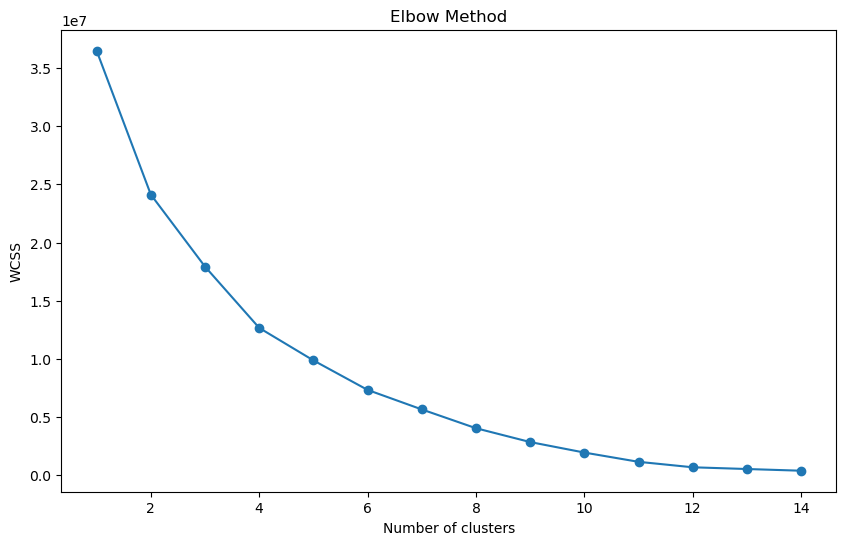

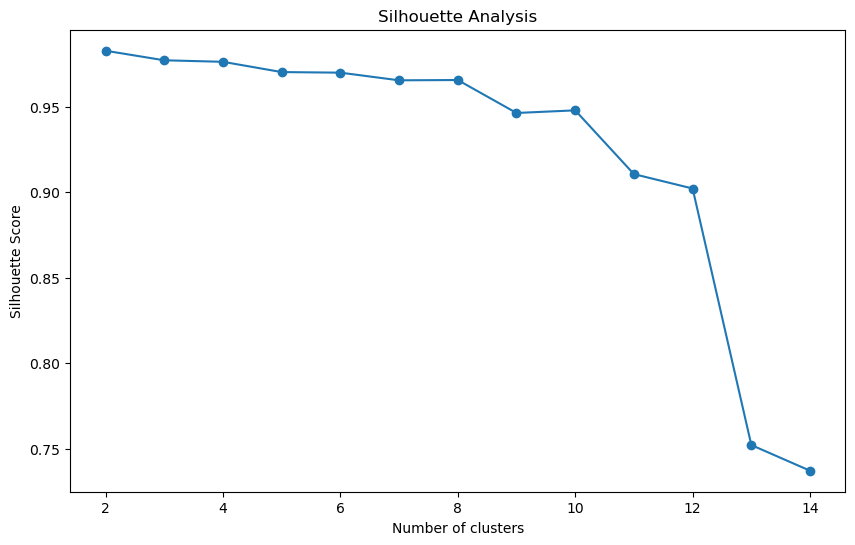

The optimal number of clusters based on train data is 2


In [6]:
# Define the feature columns
feature_columns = list(range(592, 719))  # Columns 592 to 719 as features. 720 and 721 are target values.
X = aggregated_train_df.iloc[:, feature_columns]

# Impute missing values using the mean of each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Perform Truncated SVD
n_components = 10  # Number of components to keep
svd = TruncatedSVD(n_components=n_components)
X_svd = svd.fit_transform(X_imputed)

# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_svd)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 15), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Determine the optimal number of clusters using Silhouette Analysis
silhouette_scores = []
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_svd)
    silhouette_avg = silhouette_score(X_svd, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 15), silhouette_scores, marker='o')
plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Optimal number of clusters based on the highest silhouette score
optimal_number_of_clusters_basedon_train_data = range(2, 15)[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters based on train data is {optimal_number_of_clusters_basedon_train_data}")

# Cluster the Aggregated Train Data

In [7]:
# Separate features and target
clustered_aggregated_train_df = aggregated_train_df

# Exclude VIN column (column[0]) for clustering. Column[591] is the last KOLA feature in dataframe. Col[592] to col[719] are calculated features, and col[720] and col[721] are target columns. 
X = clustered_aggregated_train_df.iloc[:, 1:591]  


# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

# Preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('clusterer', KMeans(n_clusters=optimal_number_of_clusters_basedon_train_data, random_state=42))])  # You can change the number of clusters

# Fit the pipeline to the data
pipeline.fit(X)

# Get cluster labels
cluster_labels = pipeline.named_steps['clusterer'].labels_

# Add cluster labels to the original dataframe
clustered_aggregated_train_df['CLUSTER'] = cluster_labels

# Save the dataframe with cluster labels
clustered_aggregated_train_df.to_csv('/storage/home/yqf5148/work/volvoPennState/data/dataset/clustered_aggregated_train_df.csv', index = None, mode = 'w', header=False)
# display(clustered_aggregated_train_df)
print("Clustering completed. The clustered data is saved to 'clustered_aggregated_train_df.csv'.")

Clustering completed. The clustered data is saved to 'clustered_aggregated_train_df.csv'.


# Dimentionality Reduction for Train Data

In [8]:
# Perform TruncatedSVD to reduce to 2 dimensions for visualization for train data
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(pipeline.named_steps['preprocessor'].transform(X))

# Plotting Train Data

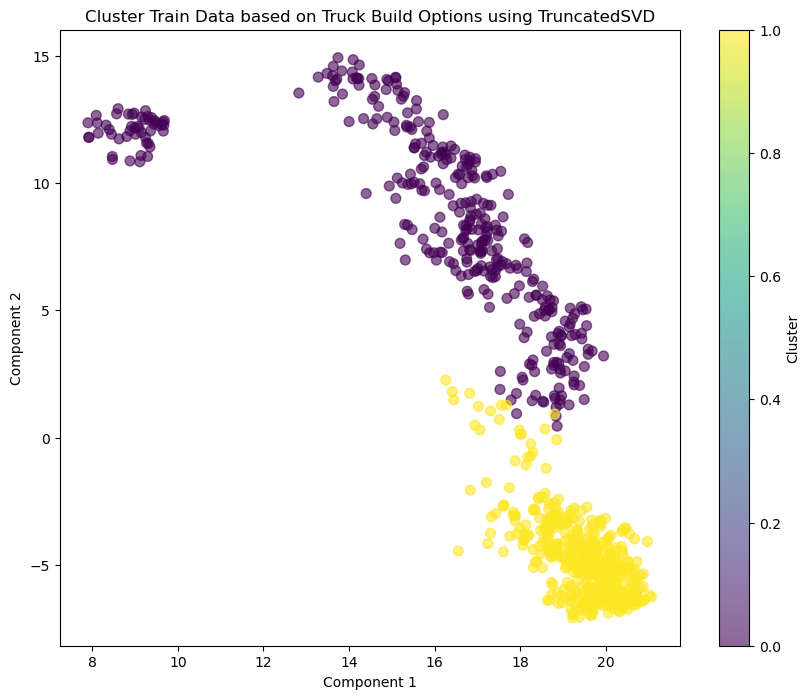

In [9]:
# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.6)
plt.title('Cluster Train Data based on Truck Build Options using TruncatedSVD')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Cluster the Aggregated Test Data

In [10]:
# Separate features and target
clustered_aggregated_test_df = aggregated_test_df

# Exclude VIN column (column[0]) for clustering. Column[591] is the last KOLA feature in dataframe. Col[592] to col[719] are calculated features, and col[720] and col[721] are target columns. 
XX = clustered_aggregated_test_df.iloc[:, 1:591]  


# Fit the pipeline to the data
pipeline.fit(XX)

# Get cluster labels
cluster_labels2 = pipeline.named_steps['clusterer'].labels_

# Add cluster labels to the original dataframe
clustered_aggregated_test_df['CLUSTER'] = cluster_labels2

# Save the dataframe with cluster labels
clustered_aggregated_test_df.to_csv('/storage/home/yqf5148/work/volvoPennState/data/dataset/clustered_aggregated_test_df.csv', index = None, mode = 'w', header=False)
# display(clustered_aggregated_test_df)
print("Clustering completed. The clustered data is saved to 'clustered_aggregated_test_df.csv'.")

Clustering completed. The clustered data is saved to 'clustered_aggregated_test_df.csv'.


# Dimentionality Reduction for Test Data

In [11]:
# Perform TruncatedSVD to reduce to 2 dimensions for visualization for test data
XX_svd = svd.fit_transform(pipeline.named_steps['preprocessor'].transform(XX))

# Plotting Test Data

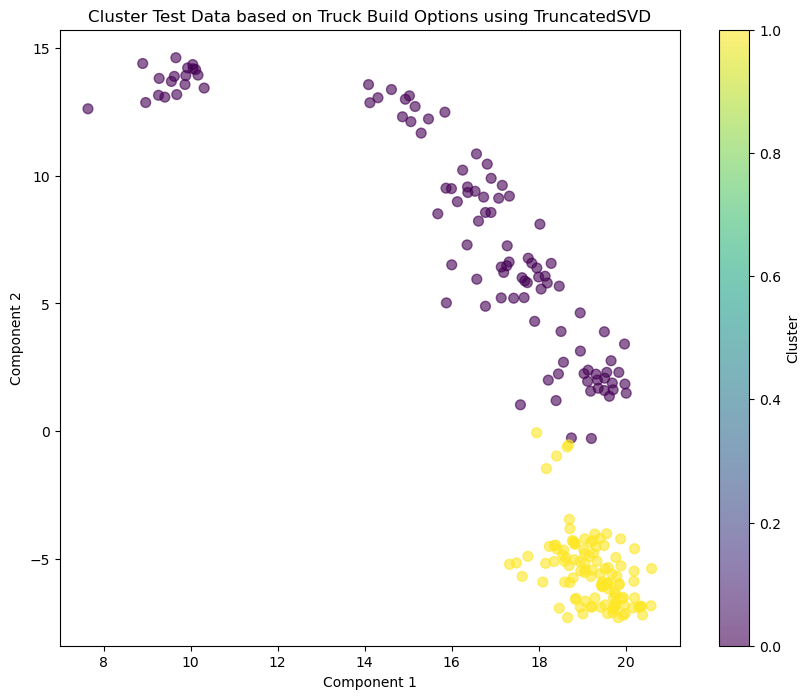

In [12]:
# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(XX_svd[:, 0], XX_svd[:, 1], c=cluster_labels2, cmap='viridis', s=50, alpha=0.6)
plt.title('Cluster Test Data based on Truck Build Options using TruncatedSVD')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [13]:
# Define columns_names based on your current setup
columns_names = ['VIN', 'ENGINE_SIZE', 'ENGINE_HP', 'VEH_TYPE'] + [s for s in df_population.columns if 'KOLA' in s] + calculated_features_minus_calendar_day + ['CLUSTER']

# Load the data
clustered_aggregated_train_df = pd.read_csv('/storage/home/yqf5148/work/volvoPennState/data/dataset/clustered_aggregated_train_df.csv', sep=',', names=columns_names, header=None)
clustered_aggregated_test_df = pd.read_csv('/storage/home/yqf5148/work/volvoPennState/data/dataset/clustered_aggregated_test_df.csv', sep=',', names=columns_names, header=None)

# Define column indices
build_option_cols = list(range(1, 592))
cluster_col = len(columns_names) - 1  # Adjust if the last column is the cluster column

# Convert non-numeric columns to string and fill NaNs to ensure no NaNs are present
for col in build_option_cols:
    clustered_aggregated_train_df.iloc[:, col] = clustered_aggregated_train_df.iloc[:, col].astype(str).fillna('')
    clustered_aggregated_test_df.iloc[:, col] = clustered_aggregated_test_df.iloc[:, col].astype(str).fillna('')

# Function to sort VINs in the train dataframe based on similarity
def sort_vins_by_similarity(test_vin_row, clustered_aggregated_train_df):
    cluster_value = test_vin_row.iloc[cluster_col]
    test_build_options = test_vin_row.iloc[build_option_cols].values.flatten()  # Ensure 1-D array
    
    # Filter clustered_aggregated_train_df to include only the VINs in the same cluster
    filtered_clustered_aggregated_train_df = clustered_aggregated_train_df[clustered_aggregated_train_df.iloc[:, cluster_col] == cluster_value]

    # Calculate the similarity between test_build_options and filtered_clustered_aggregated_train_df build options
    def calculate_similarity(row):
        train_build_options = row.iloc[build_option_cols].values.flatten()  # Ensure 1-D array
        return 1 - hamming(test_build_options, train_build_options)
    
    filtered_clustered_aggregated_train_df['similarity'] = filtered_clustered_aggregated_train_df.apply(calculate_similarity, axis=1)
    
    # Sort the filtered_clustered_aggregated_train_df based on similarity in descending order
    sorted_filtered_clustered_aggregated_train_df = filtered_clustered_aggregated_train_df.sort_values(by='similarity', ascending=False)
    return sorted_filtered_clustered_aggregated_train_df

# Create an empty dataframe to store the final results
final_sorted_filtered_clustered_aggregated_train_df_for_thisVIN = pd.DataFrame()

# Iterate over each VIN in the test dataframe and sort the VINs in the training dataframe
for index, test_vin_row in clustered_aggregated_test_df.iterrows():
    sorted_filtered_clustered_aggregated_train_df = sort_vins_by_similarity(test_vin_row, clustered_aggregated_train_df)
    
    # Create a row for the final results dataframe
    cluster_value = test_vin_row.iloc[cluster_col]
    row = [cluster_value, test_vin_row.iloc[0]] + sorted_filtered_clustered_aggregated_train_df.iloc[:, 0].tolist()  # Cluster value + Test VIN + Sorted Train VINs
    
    # Append the row to the final results dataframe 
    final_sorted_filtered_clustered_aggregated_train_df_for_thisVIN = pd.concat([final_sorted_filtered_clustered_aggregated_train_df_for_thisVIN, pd.DataFrame([row])], ignore_index=True)
 

# Write the final results dataframe to a CSV file
final_sorted_filtered_clustered_aggregated_train_df_for_thisVIN.to_csv('/storage/home/yqf5148/work/volvoPennState/data/dataset/sorted_VINs_by_similarity.csv', index=False, header=False)

print("Final results have been written to '/storage/home/yqf5148/work/volvoPennState/data/dataset/sorted_VINs_by_similarity.csv'")


/tmp/ipykernel_532753/788702791.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      505
1      505
2      500
3      500
4      445
      ... 
840    455
841    425
842    455
843    425
844    500
Name: ENGINE_HP, Length: 845, dtype: object' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  clustered_aggregated_train_df.iloc[:, col] = clustered_aggregated_train_df.iloc[:, col].astype(str).fillna('')
/tmp/ipykernel_532753/788702791.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      445
1      500
2      445
3      445
4      500
      ... 
208    325
209    355
210    405
211    500
212    405
Name: ENGINE_HP, Length: 213, dtype: object' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  clustered_aggregated_test_df.iloc[:, col] = clustered_aggregated_

Final results have been written to '/storage/home/yqf5148/work/volvoPennState/data/dataset/sorted_VINs_by_similarity.csv'
